In [30]:
import cobra

In [31]:
met = cobra.io.read_sbml_model("./data/iMcBath_rewritten.xml")

In [32]:
# we look at the optimal Biomass production/growth with default parameters
met.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.01244,0,0.00%
ch4_e,EX_ch4_e,18.46,1,100.00%
cl_e,EX_cl_e,0.03817,0,0.00%
cobalt2_e,EX_cobalt2_e,1.027E-05,0,0.00%
cu2_e,EX_cu2_e,0.000269,0,0.00%
fe2_e,EX_fe2_e,0.00109,0,0.00%
h_e,EX_h_e,1.458,0,0.00%
k_e,EX_k_e,0.03142,0,0.00%
mg2_e,EX_mg2_e,0.02198,0,0.00%
mn2_e,EX_mn2_e,3.205E-06,0,0.00%


In [33]:
met.reactions.THZPSN.reaction

'atp_c + cys__L_c + dxyl5p_c + tyr__L_c --> 4hba_c + 4mpetz_c + ala__L_c + amp_c + co2_c + h2o_c + h_c + ppi_c'

In [34]:
met.metabolites.adn_c

Metabolite identifier,adn_c
Name,adenosine
Memory address,0x07ff51433e3a0
Formula,C10H13N5O4
Compartment,c
In 3 reaction(s),"AHCi, NTD7, ADNK1"


It is clearly seen that in M. capsulatus the uptake of methane outstands among all the other uptakes. Thus, now we will check those reactions where methane is involved. Besides, we will also check the methanol-involved reactions as it is here where our main interest is placed.

IMPORTANT!! Consider using the query both with initial letter as capital letter and not capital!

Question: Why is it that the lb is placed to -18.46? Also interesting that this is exactly the optimal value obtained when optimizing.

Obtained from the paper for the model:
The uptake rate for methane in iMcBath was constrained to 18.46 mmol gDW-1 h-1, a value adopted from de la Torre et al. (2015) due to the lack of a specific measurement for M. capsulatus (Bath).

Should we take this limit value from the experimental killing curves from wet lab?

In [35]:
# this is the methane exchange reaction

met.reactions.EX_ch4_e

Reaction identifier,EX_ch4_e
Name,methane exchange
Memory address,0x07ff513de4370
Stoichiometry,ch4_e <-- methane <--
GPR,
Lower bound,-18.46
Upper bound,0.0


In [36]:
met.reactions.EX_ca2_e

Reaction identifier,EX_ca2_e
Name,Ca(2+) exchange
Memory address,0x07ff513dcdfd0
Stoichiometry,ca2_e <=> Ca(2+) <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [37]:
# this is the diffusion of methane from extracellular space to periplasm

met.reactions.query("methane","name")
met.reactions.CH4tex

Reaction identifier,CH4tex
Name,methane transport via diffusion (extracellular to periplasm)
Memory address,0x07ff513ece9a0
Stoichiometry,ch4_e <=> ch4_p methane <=> methane
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [38]:
# this is the diffusion reation of CH4 from periplasm to cytosol

met.reactions.query("CH4","name")
met.reactions.CH4trpp 

Reaction identifier,CH4trpp
Name,Diffusion CH4 between Periplasm and Cytosol
Memory address,0x07ff513ec3c40
Stoichiometry,ch4_p <=> ch4_c methane <=> methane
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [39]:
# why is methane the only medium substance to be so specifically defined and why that value

met.medium

{'EX_ca2_e': 1000.0,
 'EX_cd2_e': 1000.0,
 'EX_ch4_e': 18.46,
 'EX_cl_e': 1000.0,
 'EX_co_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_no3_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_zn2_e': 1000.0}

Question: Why do we consider the diffusion reaction without any limit? What is the relation between the methane obtained from the exchange reaction level and the diffusion? Because if we consider the diffusion with no limit and the is this periplasmatic methane that is taking further down on the reactions, where does the 18.46 limit apply?

In [40]:
# these are the three methane oxygenase reactions

print(met.reactions.SMMOi)
print(met.reactions.PMMOipp)
print(met.reactions.PMMODCipp)

SMMOi: ch4_c + h_c + nadh_c + o2_c --> h2o_c + meoh_c + nad_c
PMMOipp: ch4_p + o2_p + q8h2_im --> h2o_p + meoh_p + q8_im
PMMODCipp: ch4_p + 2.0 focytcc555_p + 2.0 h_p + o2_p --> 2.0 ficytcc555_p + h2o_p + meoh_p


In [41]:
# we only want pMMO as we do not have an sMMO in Pheast

met.reactions.SMMOi.bounds = 0,0

In [42]:
# bounds for this pMMO reaction were at 0

met.reactions.PMMOipp.bounds = 0,1000

In [43]:
# bounds for this pMMO reaction were at 0

met.reactions.PMMODCipp.bounds = 0,0

In [44]:
# growth with pMMO is better. we figured that once pMMO is active, it takes all of the available methane as
# growth does not change if sMMO is active concurrently with pMMO. the direct coupling pMMO reaction also takes
# all of the methane if other pMMO reaction is active

met.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.01244,0,0.00%
ch4_e,EX_ch4_e,18.46,1,100.00%
cl_e,EX_cl_e,0.03816,0,0.00%
cobalt2_e,EX_cobalt2_e,1.028E-05,0,0.00%
cu2_e,EX_cu2_e,0.0002689,0,0.00%
fe2_e,EX_fe2_e,0.001089,0,0.00%
h_e,EX_h_e,1.458,0,0.00%
k_e,EX_k_e,0.03141,0,0.00%
mg2_e,EX_mg2_e,0.02197,0,0.00%
mn2_e,EX_mn2_e,3.204E-06,0,0.00%


Question: Difference between both? Any reason why both are constrained not to work?

In [45]:
# now we will introduce the heterologous protein leghemoglobin with reactions for dna replication,
# transcription and translation
# as the sequences are long, we calculate the stoichiometry with a script which is on the github repo

# make new reactions



hemo_DNA_reaction = cobra.Reaction(
            'hemo_DNA',
            name = 'Leghemoglobin DNA replication',
            lower_bound = 0.0,
            upper_bound = 1000.0
        )

hemo_RNA_reaction = cobra.Reaction(
            'hemo_RNA',
            name = 'Leghemoglobin transcription',
            lower_bound = 0.0,
            upper_bound = 1000.0
        )

hemo_AA_reaction = cobra.Reaction(
            'hemo_protein',
            name = 'Leghemoglobin translation',
            lower_bound = 0.0,
            upper_bound = 1000.0
)


Hemo_Biosynthesis = cobra.Reaction(
            'Hemo_Biosynthesis',
            name = 'Leghemoglobin Biosynthesis',
            lower_bound = 0.0,
            upper_bound = 1000.0
)


Take_Out_Hemo = cobra.Reaction(
            'Take_Out_Hemo',
            name = 'Take_Out_Hemo',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)

periplasm_hemo_reaction = cobra.Reaction(
            'e_hemo_p',
            name = 'exchange of hemo_p <-> hemo_e',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)

EX_hemo = cobra.Reaction(
            'EX_hemo',
            name = 'Leghemoglobin exchange reaction',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)

# add the metabolites to be produced by these reactions


Hemo_DNA = cobra.Metabolite(
    'Hemo_DNA',
    formula='',
    name='Hemo_DNA',
    compartment='c')

Hemo_RNA = cobra.Metabolite(
    'Hemo_RNA',
    formula='',
    name='Hemo_RNA',
    compartment='c')

Hemo_AA = cobra.Metabolite(
    'Hemo_AA',
    formula='',
    name='Leghemoglobin',
    compartment='c')

hemo_c = cobra.Metabolite(
    'hemo_c',
    formula='',
    name='hemo_c',
    compartment='c')

hemo_e = cobra.Metabolite(
    'hemo_e',
    formula='',
    name='hemo_e',
    compartment='e')

hemo_p = cobra.Metabolite(
    'hemo_p',
    formula='',
    name='hemo_p',
    compartment='p')


met.add_metabolites([hemo_p,
                     hemo_c,
                     hemo_e,
                     Hemo_DNA,
                     Hemo_RNA,
                     Hemo_AA])



# add involved metabolites and stoichiometry



hemo_DNA_reaction.add_metabolites(
    {
        ### deoxynucleotides
        # A
        met.metabolites.adn_c: -1.0424,
        # T
        met.metabolites.thym_c: -1.0424,
        # C
        met.metabolites.csn_c: -0.57636,
        # G
        met.metabolites.gua_c: -0.57636,
        # ATP
        met.metabolites.atp_c: -11.00757,
        # H2O
        met.metabolites.h2o_c: -11.00757,
        # Hemo_DNA
        met.metabolites.Hemo_DNA: 1.0,
        # ADP
        met.metabolites.adp_c: 11.00757,
        # Phosphate
        met.metabolites.pi_c: 11.00757
    }
)

hemo_RNA_reaction.add_metabolites(
    {
        ### RNA nucleotides
        # A
        met.metabolites.adn_c: -1.2408,
        # U
        met.metabolites.ura_c: -0.80329,
        # C
        met.metabolites.csn_c: -0.6455,
        # G
        met.metabolites.gua_c: -0.43034,
        # ATP
        met.metabolites.atp_c: -7.48783,
        # H2O
        met.metabolites.h2o_c: -7.48783,
        # Hemo_RNA
        met.metabolites.Hemo_RNA: 1.0,
        # ADP
        met.metabolites.atp_c: 7.48783,
        # Phosphate
        met.metabolites.pi_c: 7.4878
    }
)

hemo_AA_reaction.add_metabolites(
    {
        ### Amino Acids
        # A
        met.metabolites.ala__L_c: -1.48373,
        # C, no Cystein in leghemoglobin
        # pheast.metabolites.cys__L_c:,
        # H
        met.metabolites.gln__L_c: -0.12902,
        # M
        met.metabolites.met__L_c: -0.06451,
        # T
        met.metabolites.thr__L_c: -0.38706,
        # R
        met.metabolites.arg__L_c: -0.06451,
        # E
        met.metabolites.glu__L_c: -0.6451,
        # I
        met.metabolites.ile__L_c: -0.38706,
        # F
        met.metabolites.phe__L_c: -0.58059,
        # W
        met.metabolites.trp__L_c: -0.12902,
        # N
        met.metabolites.asn__L_c: -0.25804,
        # Q
        met.metabolites.gln__L_c: -0.32255,
        # L
        met.metabolites.leu__L_c: -0.83863,
        # P
        met.metabolites.pro__L_c: -0.32255,
        # Y
        met.metabolites.tyr__L_c: -0.19353,
        # D
        met.metabolites.arg__L_c: -0.51608,
        # G
        met.metabolites.gly_c: -0.51608,
        # K
        met.metabolites.lys__L_c: -0.90314,
        # S
        met.metabolites.ser__L_c: -0.83863,
        # V
        met.metabolites.val__L_c: -0.77412,
        # ATP
        met.metabolites.atp_c: -40.22199,
        # H2O
        met.metabolites.h2o_c: -40.22199,
        # Leghemoglobin
        met.metabolites.hemo_c: 1.0,
        # ADP
        met.metabolites.adp_c: 40.22199,
        # Phosphate
        met.metabolites.pi_c: 40.22199
    }
)



Hemo_Biosynthesis.add_metabolites(
    {
        met.metabolites.Hemo_DNA: -2.8e-05,
        
        met.metabolites.Hemo_RNA: -0.0029,
        
        met.metabolites.Hemo_AA: -0.997,

        met.metabolites.hemo_c: 1.0,
    }
)

# extracellular <-> periplasm

periplasm_hemo_reaction.add_metabolites(
    {
        met.metabolites.hemo_e: -1.0,
        
        met.metabolites.hemo_p: 1.0
    }
)

# periplasm <-> cytosol

EX_hemo.add_metabolites(
    {
        met.metabolites.hemo_p: -1.0,
        
        met.metabolites.hemo_c: 1.0
    }
)


# take it out of extracelllular space

Take_Out_Hemo.add_metabolites(
        {
            met.metabolites.hemo_e : -1.0
        }
)


# add reactions to model

met.add_reactions([#hemo_DNA_reaction,
                   #hemo_RNA_reaction,
                   hemo_AA_reaction,
                   #Hemo_Biosynthesis,
                   periplasm_hemo_reaction,
                   Take_Out_Hemo,
                   EX_hemo])

In [46]:
# contraining the BIOMASS reaction
# met.reactions.BIOMASS_Mcapsulatus.bounds =  0.001, 0.001

In [47]:
new_objective = met.problem.Objective(met.reactions.hemo_protein.flux_expression)
met.objective = new_objective
met.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ch4_e,EX_ch4_e,18.46,1,100.00%
h_e,EX_h_e,6.693,0,0.00%
no3_e,EX_no3_e,1.543,0,0.00%
o2_e,EX_o2_e,27.8,0,0.00%
so4_e,EX_so4_e,0.008079,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
h2o2_c,DM_h2o2_c,-0.05655,0,0.00%
co2_e,EX_co2_e,-12.76,1,100.00%
h2o_e,EX_h2o_e,-31.92,0,0.00%
hemo_e,Take_Out_Hemo,-0.1252,0,0.00%


In [48]:
met.reactions.EX_ch4_e.bounds = -1000,1000

In [49]:
met.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ch4_e,EX_ch4_e,500,1,100.00%
h_e,EX_h_e,181.3,0,0.00%
no3_e,EX_no3_e,41.79,0,0.00%
o2_e,EX_o2_e,753.1,0,0.00%
so4_e,EX_so4_e,0.2188,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
h2o2_c,DM_h2o2_c,-1.532,0,0.00%
co2_e,EX_co2_e,-345.7,1,100.00%
h2o_e,EX_h2o_e,-864.6,0,0.00%
hemo_e,Take_Out_Hemo,-3.392,0,0.00%


In [50]:
cobra.summary.MetaboliteSummary(metabolite = met.metabolites.hemo_c, model = met)

Percent,Flux,Reaction,Definition
100.00%,3.392,hemo_protein,1.48373 ala__L_c + 0.51608 arg__L_c + 0.25804 asn__L_c + 40.22199 atp_c + 0.32255 gln__L_c + 0.6451 glu__L_c + 0.51608 gly_c + 40.22199 h2o_c + 0.38706 ile__L_c + 0.83863 leu__L_c + 0.90314 lys__L_c + 0.06451 met__L_c + 0.58059 phe__L_c + 0.32255 pro__L_c + 0.83863 ser__L_c + 0.38706 thr__L_c + 0.12902 trp__L_c + 0.19353 tyr__L_c + 0.77412 val__L_c --> 40.22199 adp_c + hemo_c + 40.22199 pi_c
Percent,Flux,Reaction,Definition
100.00%,-3.392,EX_hemo,hemo_p <=> hemo_c


In [51]:
cobra.summary.reaction_summary.ReactionSummary(reaction = met.reactions.hemo_protein, model = met)

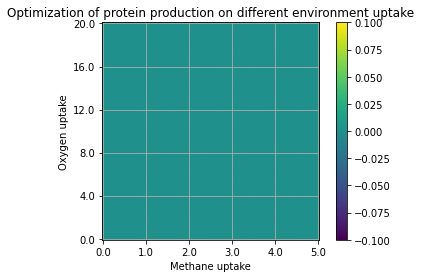

In [54]:
import numpy as np
import matplotlib.pyplot as plt
# we create a function to see how our protein production is optimize on different environments
def image_plot(model, precision, max_met, max_ox):
    plot = np.zeros([precision, precision])
    methane_vec = np.linspace(0,max_met,precision); oxygen_vec = np.linspace(0,max_ox,precision)
    for count_ox, oxygen in enumerate(oxygen_vec):
        for count_met, met in enumerate(methane_vec):
            #print(met, oxygen)
            model.reactions.EX_o2_e.bounds = oxygen, oxygen
            model.reactions.EX_ch4_e.bounds = met, met 
            result = model.optimize().objective_value
            if result < 0: 
                result = 0
            plot[(precision-1 - count_ox), count_met] = result
    label_met = np.round(np.linspace(0, max_met, 6),1)
    label_ox = np.round(np.linspace(max_ox, 0,6),1)
    ticks = np.linspace(0, precision - 1,6)
    imgplot = plt.imshow(plot)
    plt.colorbar()
    #plt.gca().invert_yaxis()
    plt.title("Optimization of protein production on different environment uptake")
    plt.xlabel("Methane uptake")
    plt.ylabel("Oxygen uptake")
    plt.xticks(ticks, label_met)
    plt.yticks(ticks, label_ox)
    plt.grid()
    return plot

max_met = 5; max_ox = 20; precision = 100
plot = image_plot(met, precision, max_met, max_ox)